In [1]:
import bayesian_multitarget_latent_factors as bmlf

In [2]:
import numpy as np
import arviz as az

In [3]:
idata = az.from_netcdf('./01_bspline_generated_example/idata.nc')

In [4]:
idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> predictions
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data
	> predictions_constant_data

In [5]:
from bayesian_multitarget_latent_factors.HMC_helper import show_data_block
from bayesian_multitarget_latent_factors.HMC_helper import show_dictionary_by_accordion

In [6]:
show_data_block('./venv/lib/python3.10/site-packages/bayesian_multitarget_latent_factors/model.stan')

data {

  // dimensions
  int<lower=1> N;             // Number of Samples
  
  int<lower=1> L1;             // Number of Locations of Observation for branch 1
  int<lower=1> L2;             // Number of Locations of Observation for branch 2
  
  int<lower=1> p1;             // Number of basis functions for branch 1
  int<lower=1> p2;             // Number of basis functions for branch 2
  
  int<lower=1> k;             // Number of Latent Factors
  int<lower=1> r;             // Number of Covariates

  // data
  matrix[L1,N] y1;             // target for branch 1
  matrix[L2,N] y2;             // target for branch 2
  matrix[r,N] X;             // covariates

  // basis functions matrices
  matrix[L1,p1] B1;
  matrix[L2,p2] B2;
  
  // hyperparameters
  real<lower=0> v;           // degrees of freedom for the student_t distribution of the latent factors (Lambda) prior
  real<lower=0> nu;          // degrees of freedom for the student_t distribution of the regression coefficients (beta

In [7]:
data_dic = \
{var: idata.constant_data[var].values[0] if len(idata.constant_data[var].values) == 1 else idata.constant_data[var].values for var in idata.constant_data}

data_dic['y1'] = idata.observed_data['y1'].values
data_dic['y2'] = idata.observed_data['y2'].values


In [8]:
show_dictionary_by_accordion(data_dic)

Accordion(children=(Output(), Output(), Output(), Output(), Output(), Output(), Output(), Output(), Output(), …

In [9]:
prior_results = []
for i in range(100):
    print(f"Executing sampling from prior no. {i}")
    prior_results.append(
        bmlf.sample_from_prior(
            data_dic, data_dic['X'], int(np.round(1.618033*100*(i + 3)))%1000000, 1000
        )
    )

Executing sampling from prior no. 0
Executing sampling from prior no. 1
Executing sampling from prior no. 2
Executing sampling from prior no. 3
Executing sampling from prior no. 4
Executing sampling from prior no. 5
Executing sampling from prior no. 6
Executing sampling from prior no. 7
Executing sampling from prior no. 8
Executing sampling from prior no. 9
Executing sampling from prior no. 10
Executing sampling from prior no. 11
Executing sampling from prior no. 12
Executing sampling from prior no. 13
Executing sampling from prior no. 14
Executing sampling from prior no. 15
Executing sampling from prior no. 16
Executing sampling from prior no. 17
Executing sampling from prior no. 18
Executing sampling from prior no. 19
Executing sampling from prior no. 20
Executing sampling from prior no. 21
Executing sampling from prior no. 22
Executing sampling from prior no. 23
Executing sampling from prior no. 24
Executing sampling from prior no. 25
Executing sampling from prior no. 26
Executing s


KeyboardInterrupt



In [12]:
from bayesian_multitarget_latent_factors.HMC_helper import get_expected_log_likelihood

In [22]:
def f(i):
    from scipy.special import logsumexp
    log_lklhood_dataset = prior_results[i][['log_lik_y']]
    aux = \
    np.array(
        [
            log_lklhood_dataset[lglklhd].sum(
                [dim for dim in log_lklhood_dataset[lglklhd].dims if dim not in ['chain','draw','sample']]
            ) for lglklhd in log_lklhood_dataset
        ]
    ).sum(axis=0).flatten()
    
    return(logsumexp(aux) - np.log(len(aux)))

In [28]:
aux = np.array([f(i) for i in range(len(prior_results))])
aux - aux.mean()

array([-122.22261785, -156.00600781,   81.07846287,   94.86781909,
        347.83707072,  806.77140491,   10.36575249, -207.20077365,
         -9.5236584 ,  235.68521414, -175.73304184,   28.10637574,
       -164.14343309,  158.76810103, -292.06049363, -203.80471362,
         36.23720381, -388.99139889,  307.48813475, -108.93724107,
        -21.31367489,  134.19348759,  -79.30444027,  588.14715924,
       -219.33217645,  155.77854344, -200.24801565,  202.82095008,
       -202.6838538 , -166.35478501,  289.66912193, -344.34805094,
         25.33132536, -251.93490015, -228.84763745, -234.55459058,
         40.86605563,   96.28571931,   25.43239742,  -86.91316306,
         22.91173986,    6.49535372,  337.4899224 , -114.63759608,
        169.92884854,  128.54918474, -322.37499388,  -29.63409077])

In [29]:
import seaborn as sns

<Axes: ylabel='Density'>

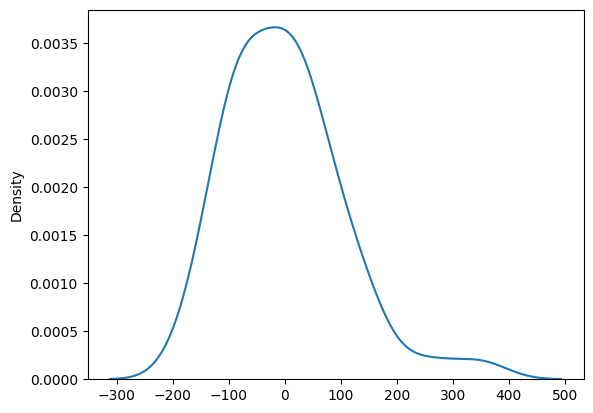

In [32]:
sns.kdeplot((aux - aux.mean())/np.log(10))

There is an oscillation of 200 orders of magnitude, so the prior likelihood CANNOT be used to decide the better model, as this is computationally unfeaseable